In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import re
import gensim.downloader as api
from wordcloud import WordCloud
import seaborn as sns

In [3]:
from keras.layers import Dense,Input,Conv1D,GlobalMaxPool1D,Dropout,Embedding,Bidirectional,GRU,MaxPooling1D,LSTM
from keras.models import Model
from keras.preprocessing import text,sequence
from keras.initializers import Constant
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
from keras.utils import plot_model
import matplotlib.pyplot as plt
from keras.metrics import AUC,Precision,Recall

In [4]:
MAX_SEQUENCE_LENGTH = 200
MAX_NUM_WORDS = 25000
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.1

In [5]:
df_train = pd.read_csv('/content/drive/My Drive/data/train/new_train.csv')
df_test = pd.read_csv('/content/drive/My Drive/data/test/new_test.csv')

In [6]:
toxic_dataset = df_train.drop(columns=['id','Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1'])
df_test = df_test.drop(columns=['id','Unnamed: 0'])

In [7]:
print('Loading word vectors.')
# Load embeddings
info = api.info()
embedding_model = api.load("glove-wiki-gigaword-300")

Loading word vectors.
[=============================================-----] 91.1% 342.6/376.1MB downloaded


In [8]:
index2word = embedding_model.index2word
vocab_size = len(embedding_model.vocab)
word2idx = {}
for index in range(vocab_size):
    word2idx[index2word[index]] = index

In [9]:
def plot_confusion_matrix(preds,true_val):
  results=confusion_matrix(preds,true_val)
  plt.figure()
  sns.heatmap(results/np.sum(results), annot=True,fmt='.2%', cmap='Blues')
  plt.plot()

In [ ]:
##graphs maybe

# MULTI-LABEL CLASSIFICATION

In [10]:
y_train = toxic_dataset[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values
y_test = df_test[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values

In [11]:
tk = text.Tokenizer(num_words=MAX_NUM_WORDS)
tk.fit_on_texts(toxic_dataset['comment_text'].fillna("").values)

In [12]:
X_train = tk.texts_to_sequences(toxic_dataset['comment_text'].fillna("").values)
X_test = tk.texts_to_sequences(df_test['comment_text'].fillna("").values)
word_index = tk.word_index

In [13]:
X_train = sequence.pad_sequences(X_train,maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(X_test,maxlen=MAX_SEQUENCE_LENGTH)

In [14]:
num_words = min(MAX_NUM_WORDS, len(word_index))
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    try:
        embedding_vector = embedding_model.get_vector(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    except:
        continue

In [15]:
nb_validation_samples = int(VALIDATION_SPLIT * X_train.shape[0])
x_train = X_train[:-nb_validation_samples]
y_t = y_train[:-nb_validation_samples]
x_val = X_train[-nb_validation_samples:]
y_val = y_train[-nb_validation_samples:]

## Class Weights

In [ ]:
class_weight = { 0:y_train.shape[0]/y_train[:,0].sum(),
                1:y_train.shape[0]/y_train[:,1].sum(),
                2:y_train.shape[0]/y_train[:,2].sum(),
                3:y_train.shape[0]/y_train[:,3].sum(),
                4:y_train.shape[0]/y_train[:,4].sum(),
                5:y_train.shape[0]/y_train[:,5].sum()
}

##Multi-Class CNN Model

In [ ]:
inp = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = Embedding(MAX_NUM_WORDS,
              EMBEDDING_DIM,
              weights=[embedding_matrix],
              input_length=MAX_SEQUENCE_LENGTH,
              trainable=False)(inp)
x = Conv1D(filters=128,kernel_size=8,strides=1,activation='relu',padding='valid')(x)
x = MaxPooling1D()(x)
x = Conv1D(filters=128,kernel_size=8,strides=1,activation='relu',padding='valid')(x)
x = GlobalMaxPool1D()(x)
x = Dense(100, activation="selu")(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="selu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation = "sigmoid")(x)

In [ ]:
model_cnn = Model(inputs=inp, outputs=x)
model_cnn.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc',AUC(),Precision(),Recall()])

model_cnn.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 200, 300)          7500000   
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 193, 128)          307328    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 96, 128)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 89, 128)           131200    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)             

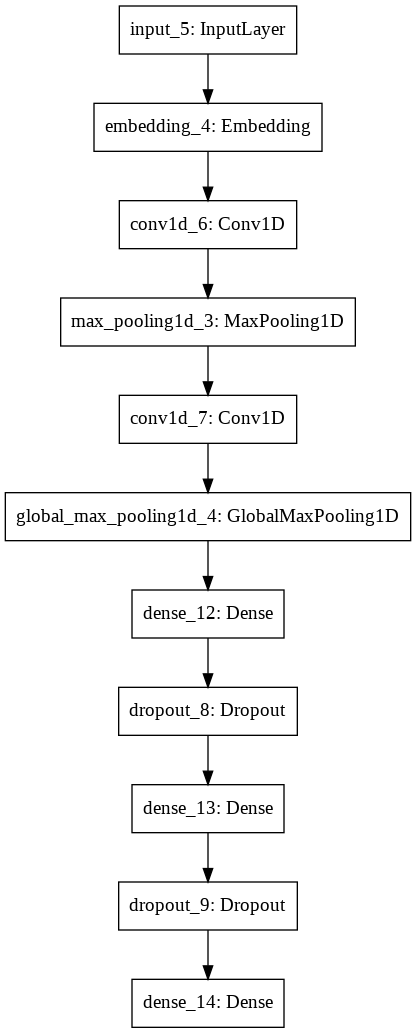

In [ ]:
plot_model(
    model_cnn,
    to_file="model.png",
)

In [ ]:
history_cnn = model_cnn.fit(x_train,y_t, batch_size=64, epochs=30,validation_data=(x_val,y_val),class_weight=class_weight)

Epoch 1/30
2244/2244 [==============================] - 28s 13ms/step - loss: 0.9161 - acc: 0.7562 - auc_7: 0.9448 - precision_7: 0.7521 - recall_7: 0.4823 - val_loss: 0.0685 - val_acc: 0.9812 - val_auc_7: 0.9622 - val_precision_7: 0.7825 - val_recall_7: 0.5252
Epoch 2/30
2244/2244 [==============================] - 27s 12ms/step - loss: 0.7591 - acc: 0.8922 - auc_7: 0.9640 - precision_7: 0.7878 - recall_7: 0.5536 - val_loss: 0.0663 - val_acc: 0.9695 - val_auc_7: 0.9637 - val_precision_7: 0.7603 - val_recall_7: 0.5760
Epoch 3/30
2244/2244 [==============================] - 26s 12ms/step - loss: 0.6808 - acc: 0.9263 - auc_7: 0.9721 - precision_7: 0.8027 - recall_7: 0.5981 - val_loss: 0.0729 - val_acc: 0.9803 - val_auc_7: 0.9508 - val_precision_7: 0.8642 - val_recall_7: 0.4459
Epoch 4/30
2244/2244 [==============================] - 26s 12ms/step - loss: 0.6000 - acc: 0.9495 - auc_7: 0.9780 - precision_7: 0.8133 - recall_7: 0.6318 - val_loss: 0.0714 - val_acc: 0.9846 - val_auc_7: 0.9481 -

### RESULTS

In [ ]:
labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

In [ ]:
preds = model_cnn.predict(X_test).round()

####Loss graph

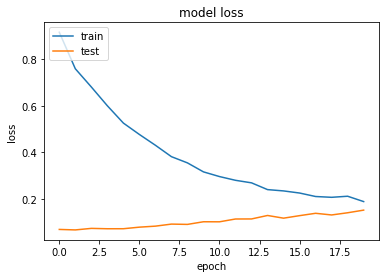

In [ ]:
plt.plot(history_cnn.history['loss'][:20])
plt.plot(history_cnn.history['val_loss'][:20])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

#### Accuracy and F1 Score

In [ ]:
for i,label in enumerate(labels):
  print("Accuray of %-20s : %.4f \n"%(label,accuracy_score(preds[:,i],y_test[:,i])))

Accuray of toxic                : 0.9008 

Accuray of severe_toxic         : 0.9924 

Accuray of obscene              : 0.9457 

Accuray of threat               : 0.9961 

Accuray of insult               : 0.9445 

Accuray of identity_hate        : 0.9882 



In [ ]:
for i,label in enumerate(labels):
  print("F1 Score of %-20s : %2.4f \n"%(label,f1_score(preds[:,i],y_test[:,i])))

F1 Score of toxic                : 0.5641 

F1 Score of severe_toxic         : 0.3013 

F1 Score of obscene              : 0.5697 

F1 Score of threat               : 0.1889 

F1 Score of insult               : 0.5127 

F1 Score of identity_hate        : 0.3568 



#### Confusion Matrix

In [ ]:
for i,label in enumerate(labels):
  print("Confusion Matrix of %-s:"%(label))
  print(confusion_matrix(preds[:,i],y_test[:,i]))

Confusion Matrix of toxic:
[[53524  1983]
 [ 4364  4107]]
Confusion Matrix of severe_toxic:
[[63386   262]
 [  225   105]]
Confusion Matrix of obscene:
[[58204  1391]
 [ 2083  2300]]
Confusion Matrix of threat:
[[63700   182]
 [   67    29]]
Confusion Matrix of insult:
[[58556  1558]
 [ 1995  1869]]
Confusion Matrix of identity_hate:
[[63011   502]
 [  255   210]]


Toxic Confusion Matrix:


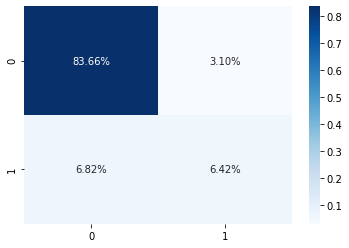

In [ ]:
print("Toxic Confusion Matrix:")
results=confusion_matrix(preds[:,0], y_test[:,0])
sns.heatmap(results/np.sum(results), annot=True,fmt='.2%', cmap='Blues') #toxic

Severe Toxic Confusion Matrix:


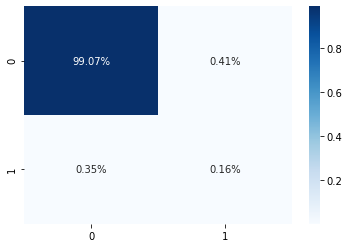

In [ ]:
print("Severe Toxic Confusion Matrix:")
results=confusion_matrix(preds[:,1], y_test[:,1])
sns.heatmap(results/np.sum(results), annot=True,fmt='.2%', cmap='Blues') #toxic

Obscene Confusion Matrix:


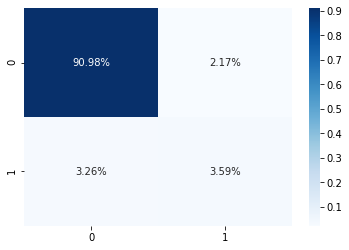

In [ ]:
print("Obscene Confusion Matrix:")
results=confusion_matrix(preds[:,2], y_test[:,2])
sns.heatmap(results/np.sum(results), annot=True,fmt='.2%', cmap='Blues') #toxic

Threat Confusion Matrix:


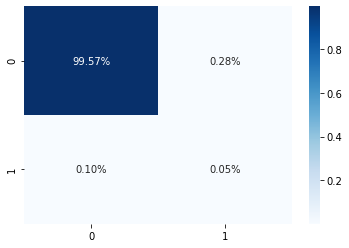

In [ ]:
print("Threat Confusion Matrix:")
results=confusion_matrix(preds[:,3], y_test[:,3])
sns.heatmap(results/np.sum(results), annot=True,fmt='.2%', cmap='Blues') #toxic

Insult Confusion Matrix:


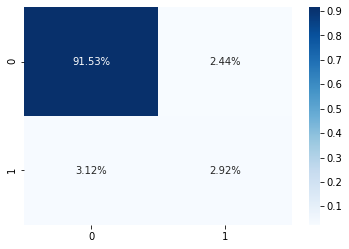

In [ ]:
print("Insult Confusion Matrix:")
results=confusion_matrix(preds[:,4], y_test[:,4])
sns.heatmap(results/np.sum(results), annot=True,fmt='.2%', cmap='Blues') #toxic

Identity Hate Confusion Matrix:


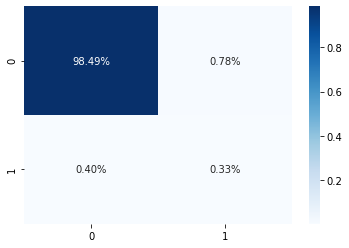

In [ ]:
print("Identity Hate Confusion Matrix:")
results=confusion_matrix(preds[:,5], y_test[:,5])
sns.heatmap(results/np.sum(results), annot=True,fmt='.2%', cmap='Blues') #toxic

## LSTM Model

In [ ]:
inp = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = Embedding(MAX_NUM_WORDS,
              EMBEDDING_DIM,
              weights=[embedding_matrix],
              input_length=MAX_SEQUENCE_LENGTH,
              trainable=True)(inp)
x = Bidirectional(LSTM(64, return_sequences = True))(x)
x = Bidirectional(LSTM(128, return_sequences = True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(100, activation="selu")(x)
x = Dropout(0.3)(x)
x = Dense(50, activation="selu")(x)
x = Dropout(0.3)(x)
x = Dense(6, activation = "sigmoid")(x)

In [ ]:
model_lstm = Model(inputs=inp, outputs=x)
model_lstm.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc',AUC(),Precision(),Recall()])

model_lstm.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 300)          7500000   
_________________________________________________________________
bidirectional (Bidirectional (None, 200, 128)          186880    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 256)          263168    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               25700     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)              

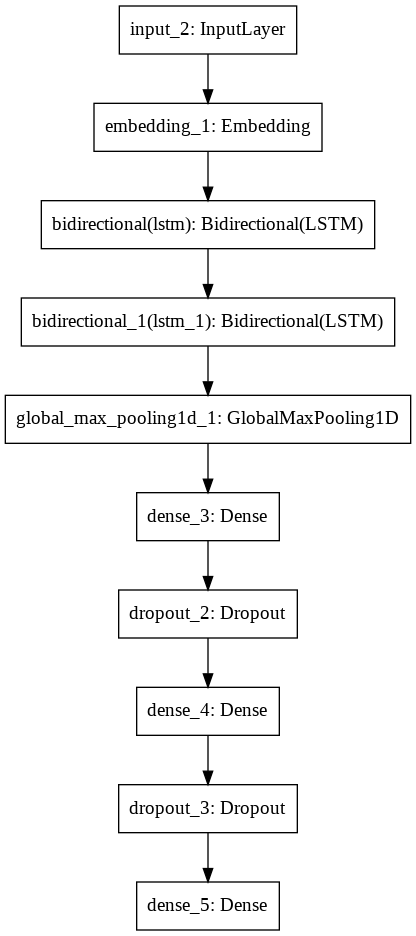

In [ ]:
plot_model(
    model_lstm,
    to_file="model.png",
)

In [ ]:
history_lstm = model_lstm.fit(x_train,y_t, batch_size=64, epochs=7,validation_data=(x_val,y_val),class_weight=class_weight)

Epoch 1/7
2244/2244 [==============================] - 261s 117ms/step - loss: 0.7292 - acc: 0.6259 - auc_2: 0.9703 - precision_2: 0.7726 - recall_2: 0.6129 - val_loss: 0.0500 - val_acc: 0.7059 - val_auc_2: 0.9795 - val_precision_2: 0.8226 - val_recall_2: 0.6393
Epoch 2/7
2244/2244 [==============================] - 265s 118ms/step - loss: 0.5320 - acc: 0.7571 - auc_2: 0.9854 - precision_2: 0.8048 - recall_2: 0.7046 - val_loss: 0.0472 - val_acc: 0.9810 - val_auc_2: 0.9814 - val_precision_2: 0.7691 - val_recall_2: 0.7433
Epoch 3/7
2244/2244 [==============================] - 265s 118ms/step - loss: 0.4439 - acc: 0.8151 - auc_2: 0.9896 - precision_2: 0.8206 - recall_2: 0.7501 - val_loss: 0.0521 - val_acc: 0.9872 - val_auc_2: 0.9699 - val_precision_2: 0.7884 - val_recall_2: 0.7018
Epoch 4/7
2244/2244 [==============================] - 266s 119ms/step - loss: 0.3713 - acc: 0.7797 - auc_2: 0.9924 - precision_2: 0.8405 - recall_2: 0.7996 - val_loss: 0.0540 - val_acc: 0.9551 - val_auc_2: 0.96

### RESULTS

In [ ]:
labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

In [ ]:
preds = model_lstm.predict(X_test).round()

#### Accuracy and Loss graph

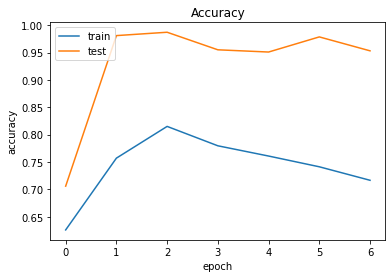

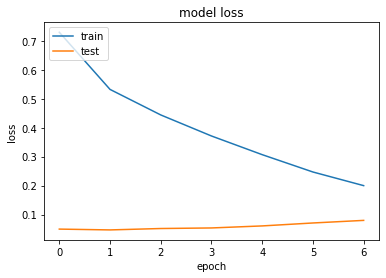

In [ ]:
plt.plot(history_lstm.history['acc'][:20])
plt.plot(history_lstm.history['val_acc'][:20])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()
plt.plot(history_lstm.history['loss'][:20])
plt.plot(history_lstm.history['val_loss'][:20])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

#### Accuracy and F1 Score

In [ ]:
for i,label in enumerate(labels):
  print("Accuray of %-20s : %.4f \n"%(label,accuracy_score(preds[:,i],y_test[:,i])))

Accuray of toxic                : 0.9088 

Accuray of severe_toxic         : 0.9918 

Accuray of obscene              : 0.9569 

Accuray of threat               : 0.9947 

Accuray of insult               : 0.9505 

Accuray of identity_hate        : 0.9871 



In [ ]:
for i,label in enumerate(labels):
  print("F1 Score of %-20s : %2.4f \n"%(label,f1_score(preds[:,i],y_test[:,i])))

F1 Score of toxic                : 0.6281 

F1 Score of severe_toxic         : 0.3800 

F1 Score of obscene              : 0.6613 

F1 Score of threat               : 0.3986 

F1 Score of insult               : 0.5931 

F1 Score of identity_hate        : 0.4985 



#### Confusion Matrix

In [ ]:
for i,label in enumerate(labels):
  print("Confusion Matrix of %-s:"%(label))
  print(confusion_matrix(preds[:,i],y_test[:,i]))

Confusion Matrix of toxic:
[[53222  1166]
 [ 4666  4924]]
Confusion Matrix of severe_toxic:
[[63296   207]
 [  315   160]]
Confusion Matrix of obscene:
[[58534  1002]
 [ 1753  2689]]
Confusion Matrix of threat:
[[63524    98]
 [  243   113]]
Confusion Matrix of insult:
[[58506  1120]
 [ 2045  2307]]
Confusion Matrix of identity_hate:
[[62743   302]
 [  523   410]]


Toxic Confusion Matrix:


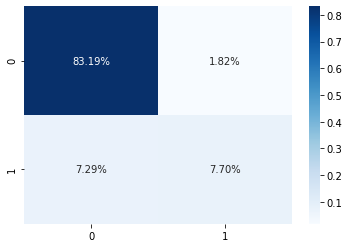

In [ ]:
print("Toxic Confusion Matrix:")
results=confusion_matrix(preds[:,0], y_test[:,0])
sns.heatmap(results/np.sum(results), annot=True,fmt='.2%', cmap='Blues') #toxic

Severe Toxic Confusion Matrix:


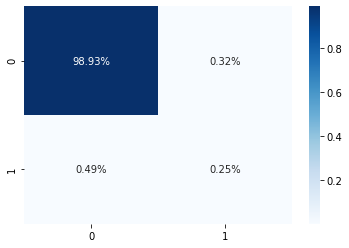

In [ ]:
print("Severe Toxic Confusion Matrix:")
results=confusion_matrix(preds[:,1], y_test[:,1])
sns.heatmap(results/np.sum(results), annot=True,fmt='.2%', cmap='Blues') #toxic

Obscene Confusion Matrix:


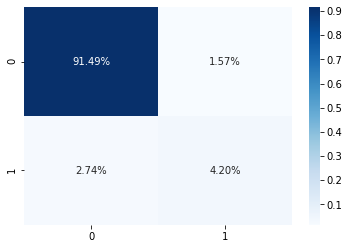

In [ ]:
print("Obscene Confusion Matrix:")
results=confusion_matrix(preds[:,2], y_test[:,2])
sns.heatmap(results/np.sum(results), annot=True,fmt='.2%', cmap='Blues') #toxic

Threat Confusion Matrix:


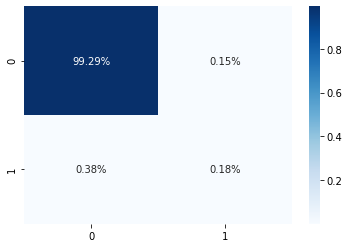

In [ ]:
print("Threat Confusion Matrix:")
results=confusion_matrix(preds[:,3], y_test[:,3])
sns.heatmap(results/np.sum(results), annot=True,fmt='.2%', cmap='Blues') 

Insult Confusion Matrix:


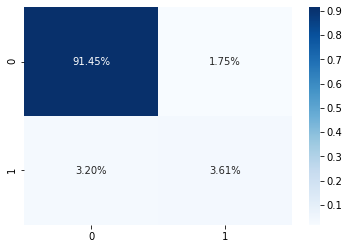

In [ ]:
print("Insult Confusion Matrix:")
results=confusion_matrix(preds[:,4], y_test[:,4])
sns.heatmap(results/np.sum(results), annot=True,fmt='.2%', cmap='Blues') #toxic

Identity Hate Confusion Matrix:


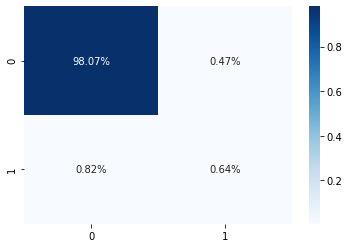

In [ ]:
print("Identity Hate Confusion Matrix:")
results=confusion_matrix(preds[:,5], y_test[:,5])
sns.heatmap(results/np.sum(results), annot=True,fmt='.2%', cmap='Blues') #toxic